##Tiny NeRF
This is a simplied version of the method presented in *NeRF: Representing Scenes as Neural Radiance Fields for View Synthesis*

[Project Website](http://www.matthewtancik.com/nerf)

[arXiv Paper](https://arxiv.org/abs/2003.08934)

[Full Code](github.com/bmild/nerf)

Components not included in the notebook
*   5D input including view directions
*   Hierarchical Sampling



In [1]:
try:
  import google.colab
  IN_COLAB = True
except:
  IN_COLAB = False

if IN_COLAB:
    %tensorflow_version

import os, sys
import tensorflow as tf
tf.compat.v1.enable_eager_execution()

from tqdm import tqdm_notebook as tqdm
import numpy as np
import matplotlib.pyplot as plt

Colab only includes TensorFlow 2.x; %tensorflow_version has no effect.


In [2]:
if not os.path.exists('tiny_nerf_data.npz'):
    !wget http://cseweb.ucsd.edu/~viscomp/projects/LF/papers/ECCV20/nerf/tiny_nerf_data.npz

--2024-11-14 06:37:54--  http://cseweb.ucsd.edu/~viscomp/projects/LF/papers/ECCV20/nerf/tiny_nerf_data.npz
Resolving cseweb.ucsd.edu (cseweb.ucsd.edu)... 132.239.8.30
Connecting to cseweb.ucsd.edu (cseweb.ucsd.edu)|132.239.8.30|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://cseweb.ucsd.edu//~viscomp/projects/LF/papers/ECCV20/nerf/tiny_nerf_data.npz [following]
--2024-11-14 06:37:54--  https://cseweb.ucsd.edu//~viscomp/projects/LF/papers/ECCV20/nerf/tiny_nerf_data.npz
Connecting to cseweb.ucsd.edu (cseweb.ucsd.edu)|132.239.8.30|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 12727482 (12M)
Saving to: ‘tiny_nerf_data.npz’

tiny_nerf_data.npz  100%[===================>]  12.14M  6.46MB/s    in 1.9s    

2024-11-14 06:37:57 (6.46 MB/s) - ‘tiny_nerf_data.npz’ saved [12727482/12727482]



In [13]:
!pip install scikit-image tensorflow lpips torch

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.8/53.8 kB 3.6 MB/s eta 0:00:00


# Load Input Images and Poses

(106, 100, 100, 3) (106, 4, 4) 138.88887889922103


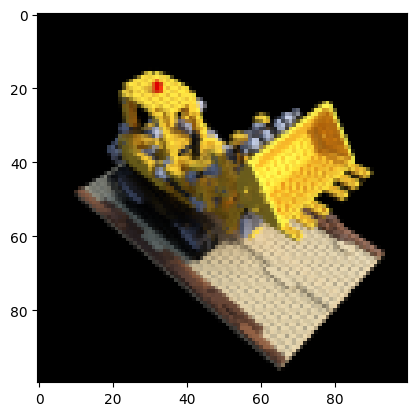

In [3]:
data = np.load('tiny_nerf_data.npz')
images = data['images']
poses = data['poses']
focal = data['focal']
H, W = images.shape[1:3]
print(images.shape, poses.shape, focal)

testimg, testpose = images[101], poses[101]
images = images[:100,...,:3]
poses = poses[:100]

plt.imshow(testimg)
plt.show()

# Optimize ZipNeRF

In [4]:
def posenc(x):
  rets = [x]
  for i in range(L_embed):
    for fn in [tf.sin, tf.cos]:
      rets.append(fn(2.**i * x))
  return tf.concat(rets, -1)

L_embed = 6
embed_fn = posenc

def init_model(D=8, W=256):
    relu = tf.keras.layers.ReLU()
    dense = lambda W=W, act=relu : tf.keras.layers.Dense(W, activation=act)

    inputs = tf.keras.Input(shape=(3 + 3*2*L_embed,))
    outputs = inputs
    for i in range(D):
        outputs = dense()(outputs)
        if i%4==0 and i>0:
            outputs = tf.keras.layers.Concatenate(axis=-1)([outputs, inputs])
    outputs = dense(4, act=None)(outputs)

    model = tf.keras.Model(inputs=inputs, outputs=outputs)
    return model


def get_rays(H, W, focal, c2w):
    i, j = tf.meshgrid(tf.range(W, dtype=tf.float32), tf.range(H, dtype=tf.float32), indexing='xy')
    dirs = tf.stack([(i-W*.5)/focal, -(j-H*.5)/focal, -tf.ones_like(i)], -1)
    rays_d = tf.reduce_sum(dirs[..., np.newaxis, :] * c2w[:3,:3], -1)
    rays_o = tf.broadcast_to(c2w[:3,-1], tf.shape(rays_d))
    return rays_o, rays_d



def multisample_rays(rays_o, rays_d, near, far, N_samples, rand=False):
    # Implement a multisampling pattern along the conical frustum
    z_vals = improved_proposal_network(rays_o, rays_d, near, far, N_samples)
    if rand:
        # Add multisample pattern (6-sample) for anti-aliasing
        z_vals += tf.random.uniform(list(rays_o.shape[:-1]) + [N_samples]) * (far - near) / N_samples
    pts = rays_o[..., None, :] + rays_d[..., None, :] * z_vals[..., :, None]
    return pts, z_vals

def render_rays(network_fn, rays_o, rays_d, near, far, N_samples, rand=False):
    # Compute 3D query points with improved proposal network
    z_vals = improved_proposal_network(rays_o, rays_d, near, far, N_samples)
    pts = rays_o[..., None, :] + rays_d[..., None, :] * z_vals[..., :, None]

    # Flatten points for input to the network
    pts_flat = tf.reshape(pts, [-1, 3])

    # Apply positional encoding and pass through the network
    pts_flat = embed_fn(pts_flat)
    raw = network_fn(pts_flat)

    # Reshape network output
    raw = tf.reshape(raw, list(pts.shape[:-1]) + [4])

    # Compute opacities (alpha) and colors (rgb)
    sigma_a = tf.nn.relu(raw[..., 3])  # Volume density
    rgb = tf.math.sigmoid(raw[..., :3])  # Color

    # Perform volume rendering using the weights
    dists = tf.concat([z_vals[..., 1:] - z_vals[..., :-1], tf.broadcast_to([1e10], z_vals[..., :1].shape)], -1)
    alpha = 1.0 - tf.exp(-sigma_a * dists)
    weights = alpha * tf.math.cumprod(1.0 - alpha + 1e-10, axis=-1, exclusive=True)

    rgb_map = tf.reduce_sum(weights[...,None] * rgb, -2)
    depth_map = tf.reduce_sum(weights * z_vals, axis=-1)
    acc_map = tf.reduce_sum(weights, axis=-1)

    return rgb_map, depth_map, acc_map


def improved_proposal_network(rays_o, rays_d, near, far, N_samples):
    # Implement dense resampling to avoid z-aliasing
    z_vals = tf.linspace(near, far, N_samples)
    # Dense resampling to capture thin structures
    z_vals += tf.random.uniform(list(rays_o.shape[:-1]) + [N_samples]) * (far - near) / N_samples
    return z_vals



# Grid-Based Representation

In [5]:
class GridFeatureRepresentation(tf.keras.layers.Layer):
    def __init__(self, grid_size=128):
        super(GridFeatureRepresentation, self).__init__()
        self.grid_size = grid_size
        self.grid = tf.Variable(tf.random.normal([grid_size, grid_size, grid_size, 3]), trainable=True)

    def call(self, x):
        # Convert x from world coordinates to grid coordinates
        x_grid = (x + 1) * 0.5 * (self.grid_size - 1)
        x_grid = tf.clip_by_value(x_grid, 0, self.grid_size - 1)
        return tf.gather_nd(self.grid, tf.cast(x_grid, tf.int32))

from tensorflow.keras.layers import Concatenate, Lambda

def init_model(D=8, W=256, grid_size=128):
    relu = tf.keras.layers.ReLU()
    dense = lambda W=W, act=relu: tf.keras.layers.Dense(W, activation=act)

    # Input tensor with positional encoding (shape: (None, 3 + 3 * 2 * L_embed))
    inputs = tf.keras.Input(shape=(3 + 3 * 2 * L_embed,))

    # Use a Lambda layer to slice the first 3 dimensions (x, y, z coordinates)
    coords = Lambda(lambda x: x[:, :3])(inputs)

    # Use grid-based feature representation on 3D coordinates
    grid_layer = GridFeatureRepresentation(grid_size)
    grid_features = grid_layer(coords)  # Apply grid-based feature representation

    # Use Keras Concatenate to combine grid features with the original input (positional encoding)
    outputs = Concatenate(axis=-1)([grid_features, inputs])

    # Pass through the MLP layers
    for i in range(D):
        outputs = dense()(outputs)
        if i % 4 == 0 and i > 0:
            outputs = Concatenate(axis=-1)([outputs, inputs])

    outputs = dense(4, act=None)(outputs)

    model = tf.keras.Model(inputs=inputs, outputs=outputs)
    return model



Here we optimize the model. We plot a rendered holdout view and its PSNR every 50 iterations.

0 0.16103562355041504 secs per iter


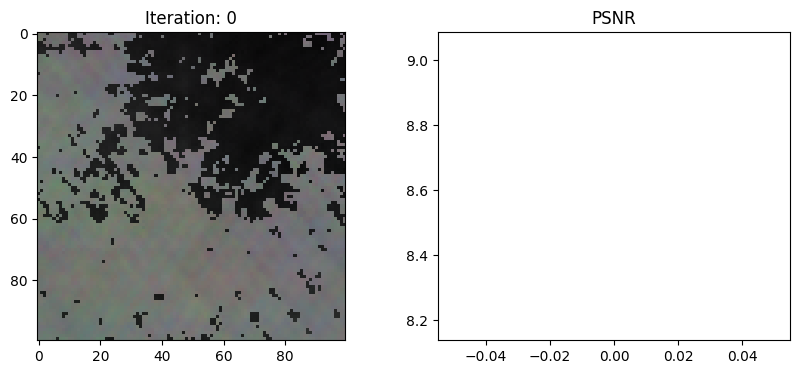

25 0.1461626434326172 secs per iter


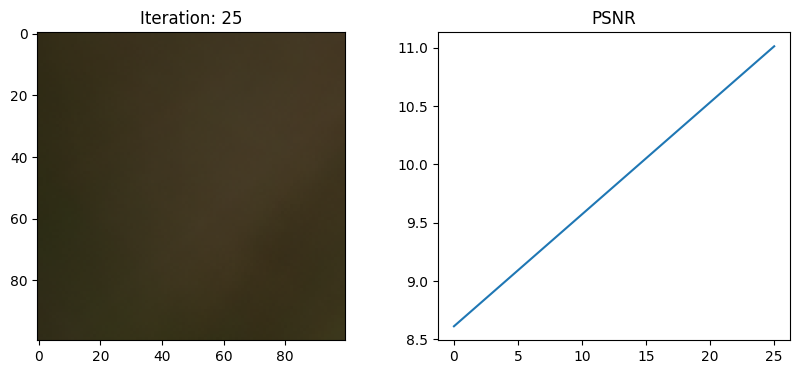

50 0.14374552726745604 secs per iter


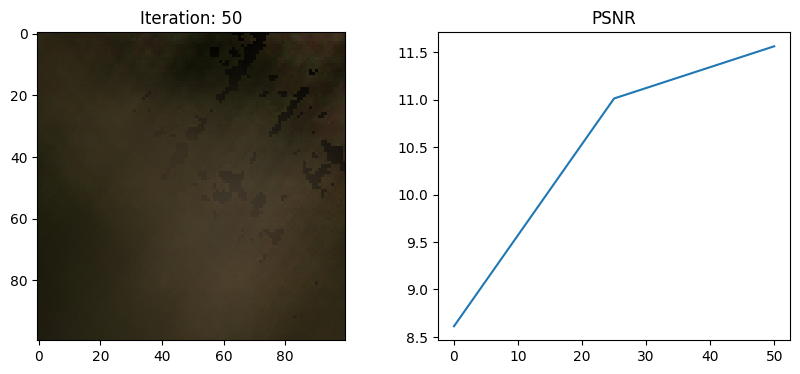

75 0.14594042778015137 secs per iter


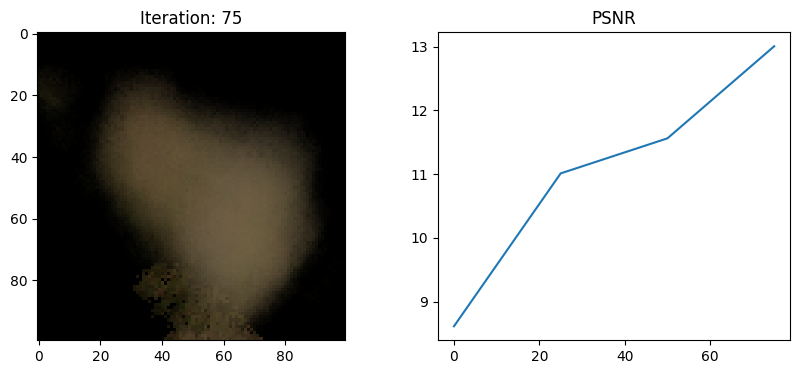

100 0.1431925392150879 secs per iter


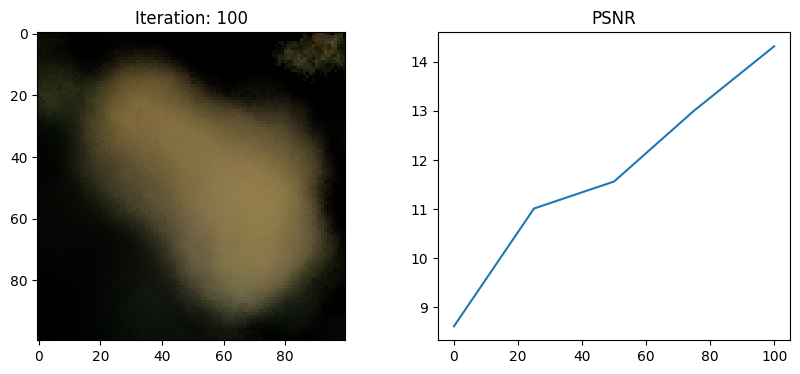

125 0.14412487030029297 secs per iter


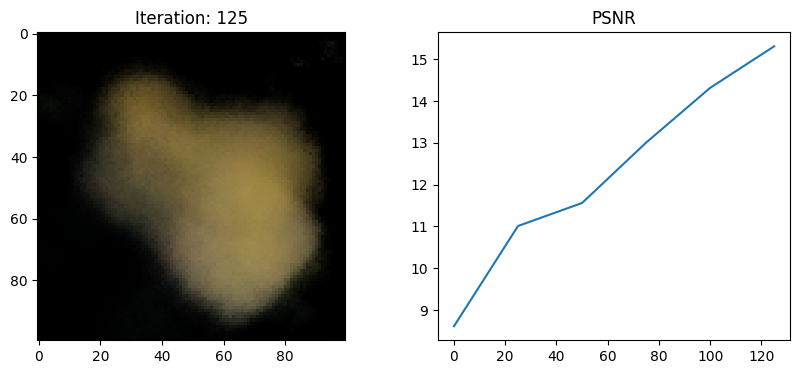

150 0.1438830852508545 secs per iter


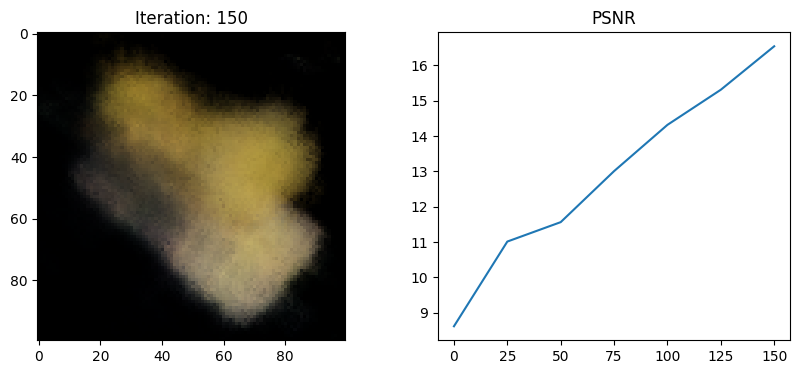

175 0.14388422966003417 secs per iter


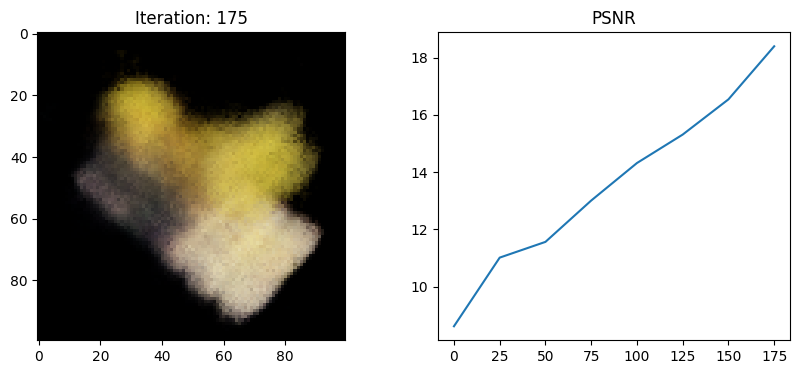

200 0.14298301696777344 secs per iter


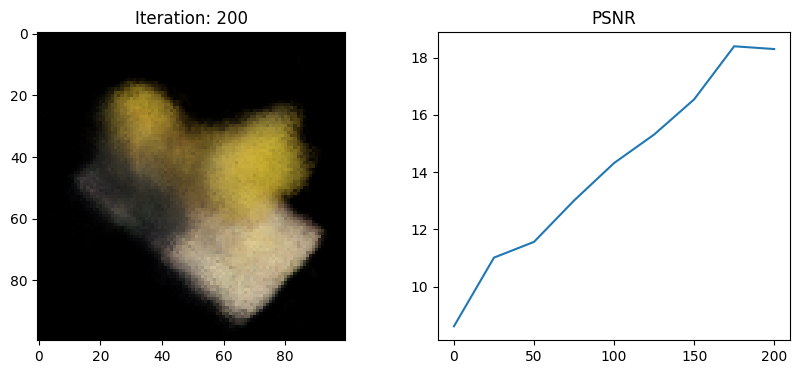

225 0.14513425827026366 secs per iter


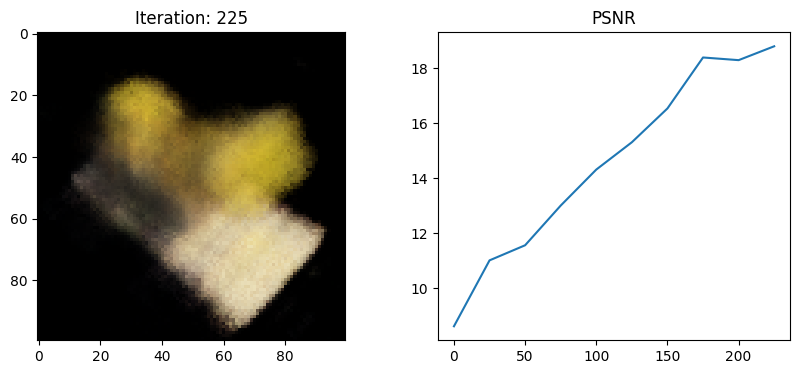

250 0.1401816177368164 secs per iter


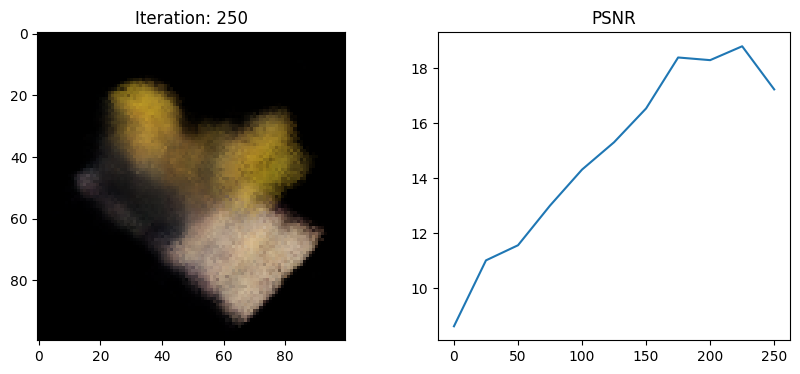

275 0.14997001647949218 secs per iter


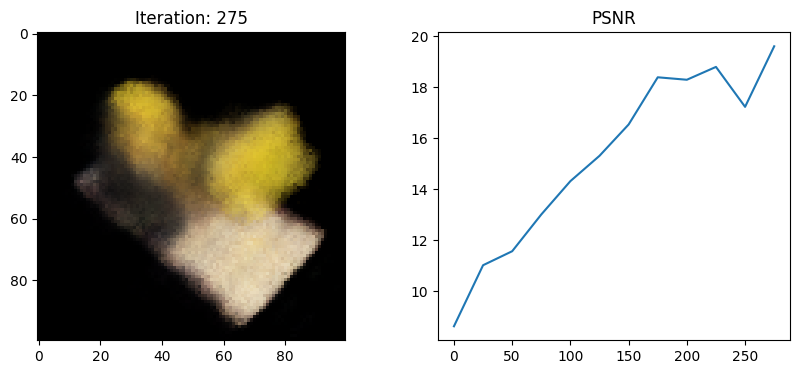

300 0.14195602416992187 secs per iter


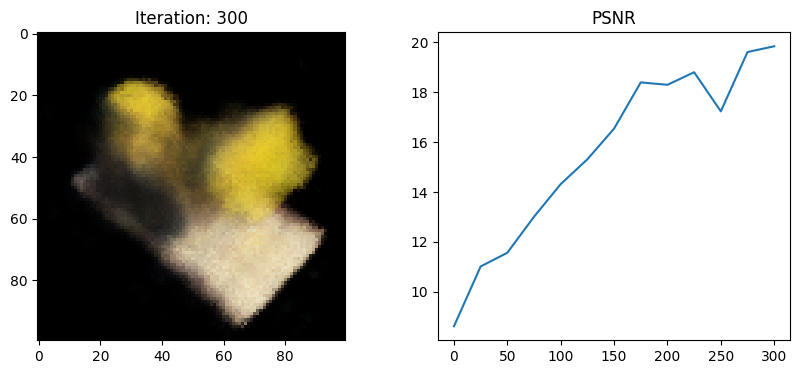

325 0.14180489540100097 secs per iter


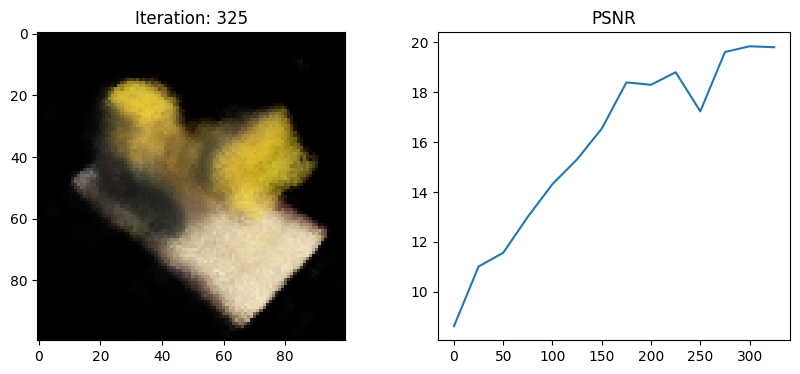

350 0.14140658378601073 secs per iter


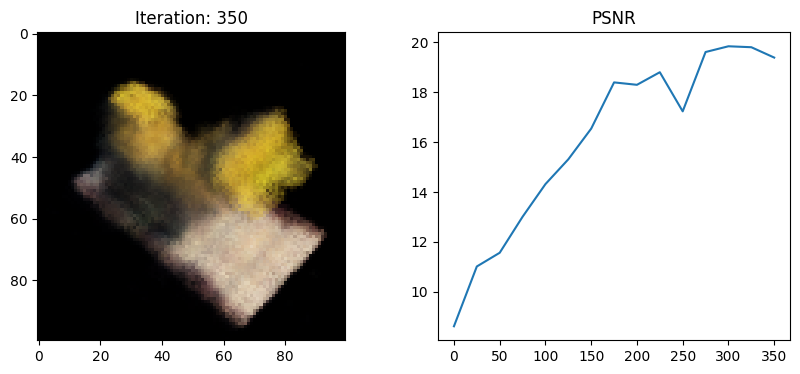

375 0.14185325622558595 secs per iter


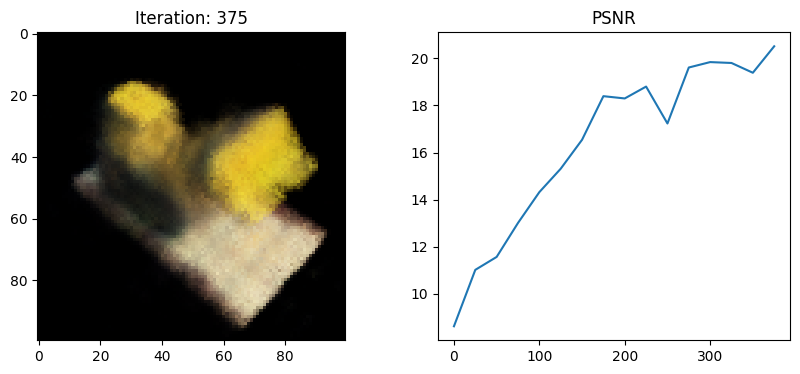

400 0.1426660633087158 secs per iter


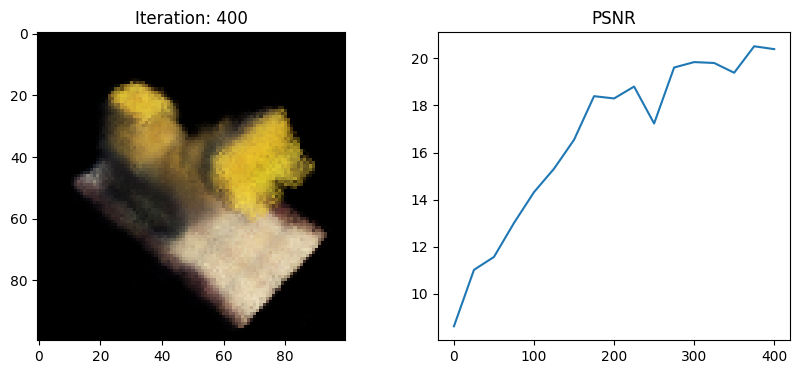

425 0.1415743923187256 secs per iter


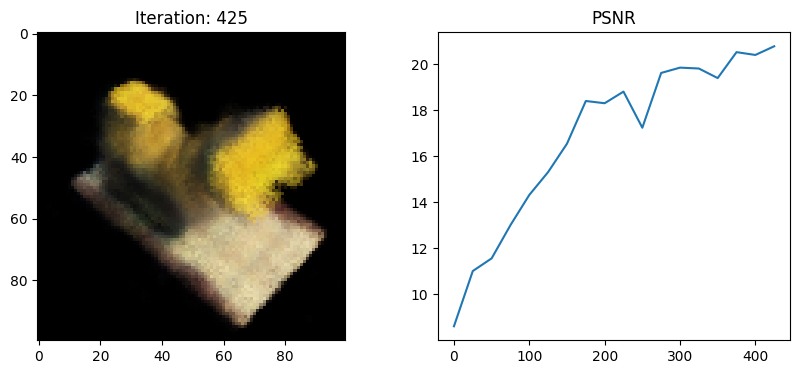

450 0.14029508590698242 secs per iter


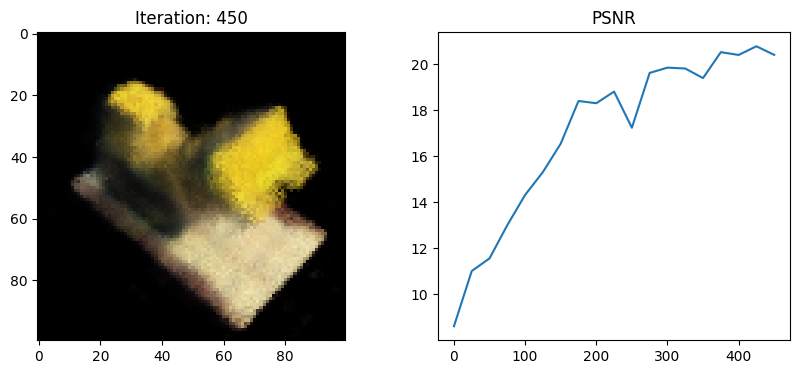

475 0.14325449943542481 secs per iter


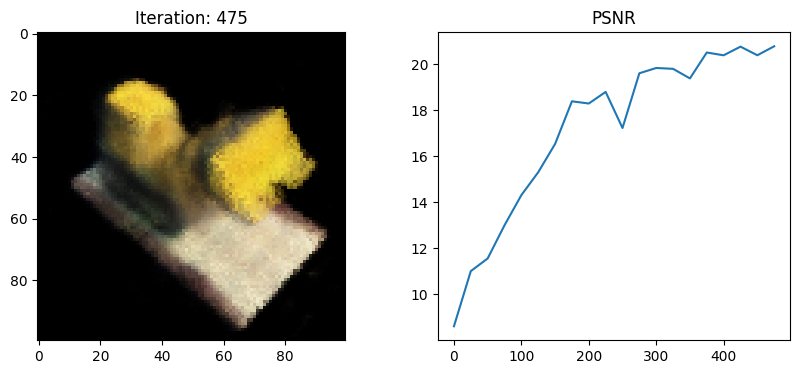

500 0.14129050254821776 secs per iter


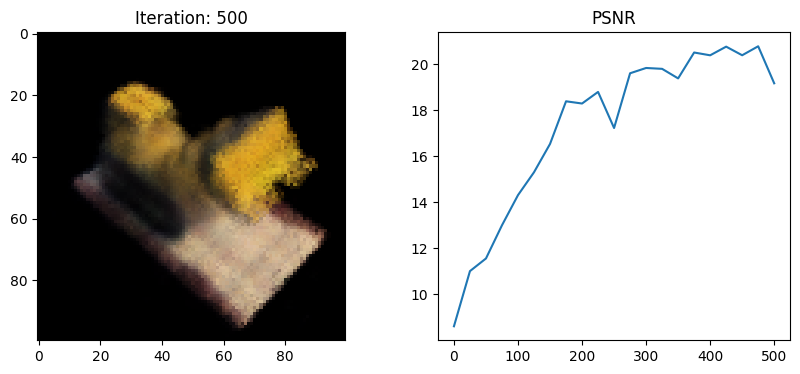

525 0.14110532760620118 secs per iter


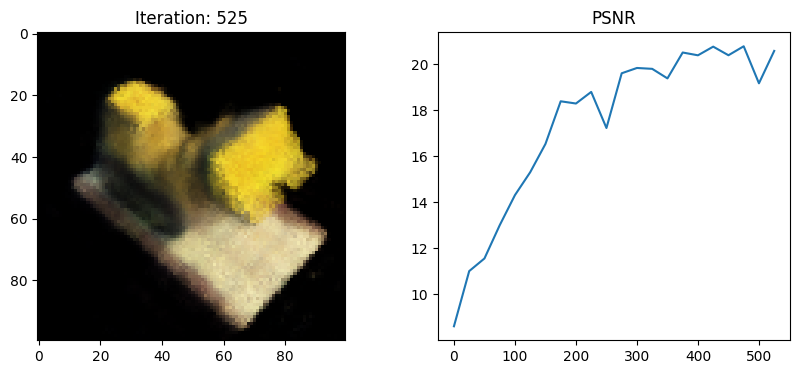

550 0.14140103340148927 secs per iter


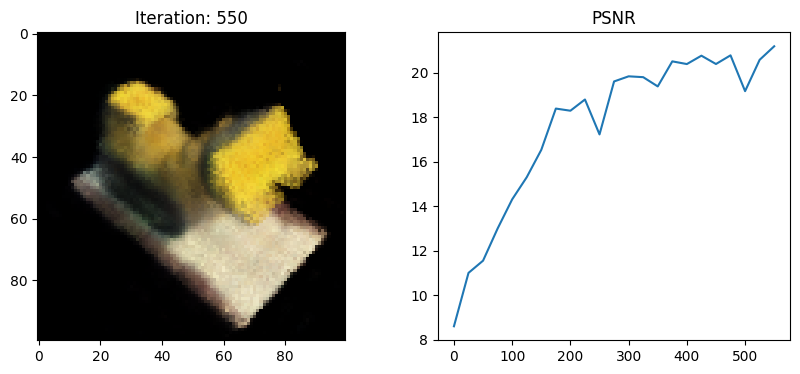

575 0.142487096786499 secs per iter


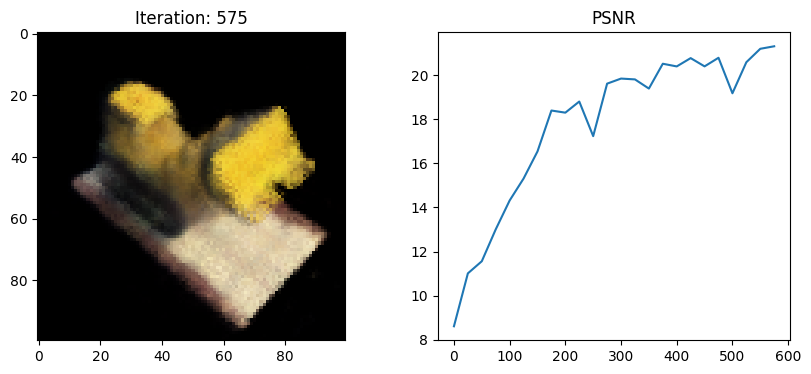

600 0.14262463569641112 secs per iter


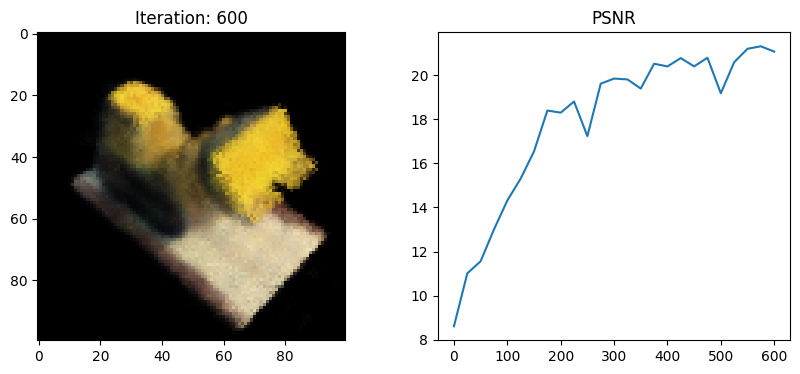

625 0.14233381271362305 secs per iter


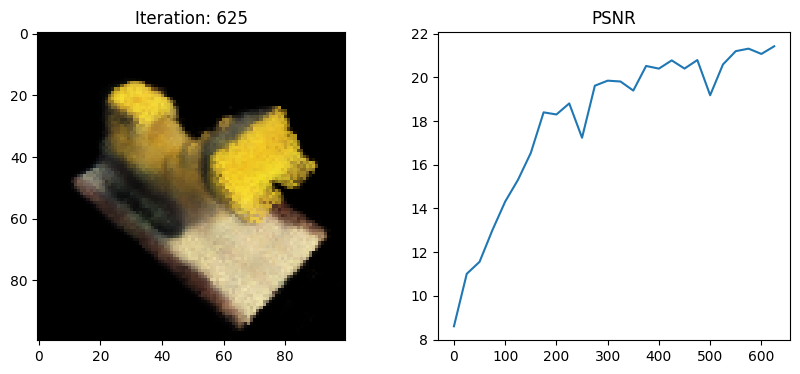

650 0.14280942916870118 secs per iter


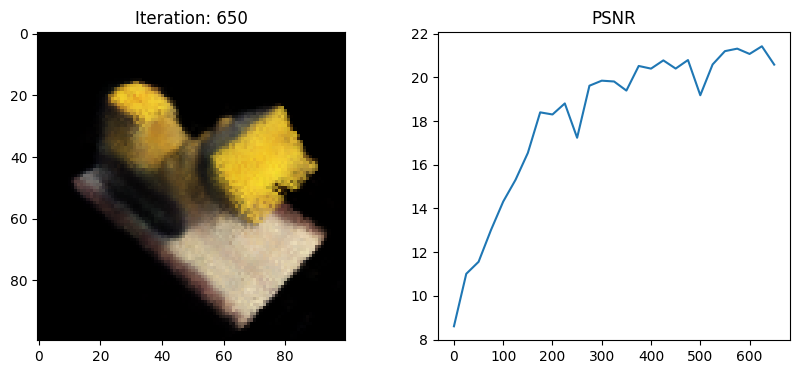

675 0.14180828094482423 secs per iter


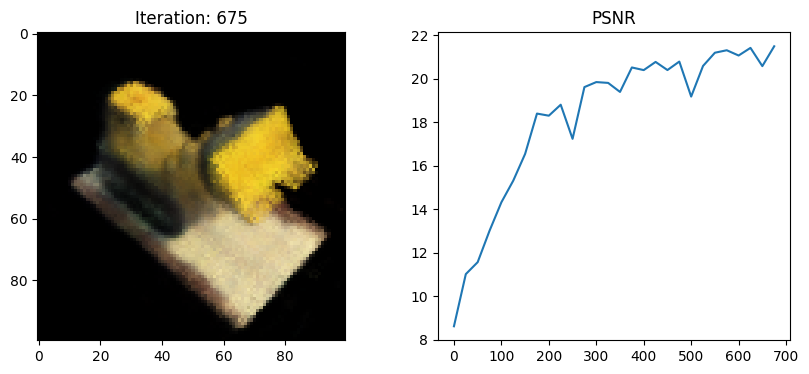

700 0.14206640243530275 secs per iter


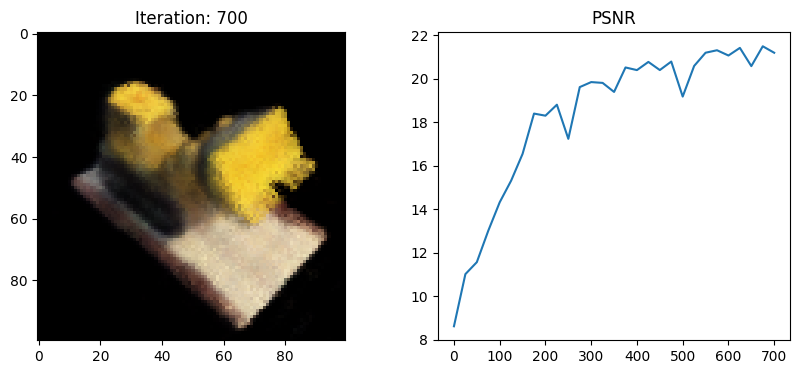

725 0.1514070987701416 secs per iter


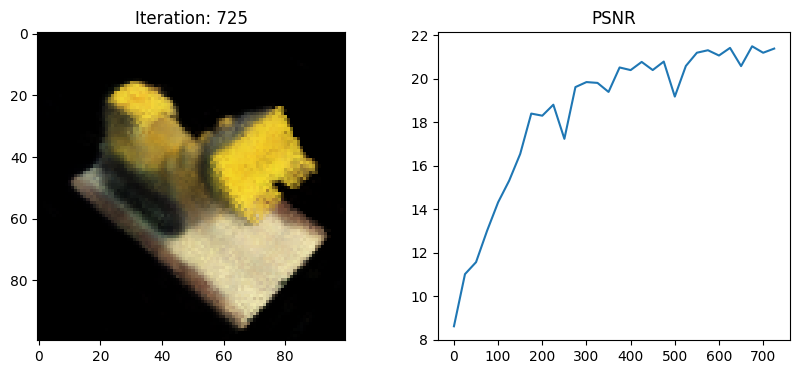

750 0.1400836753845215 secs per iter


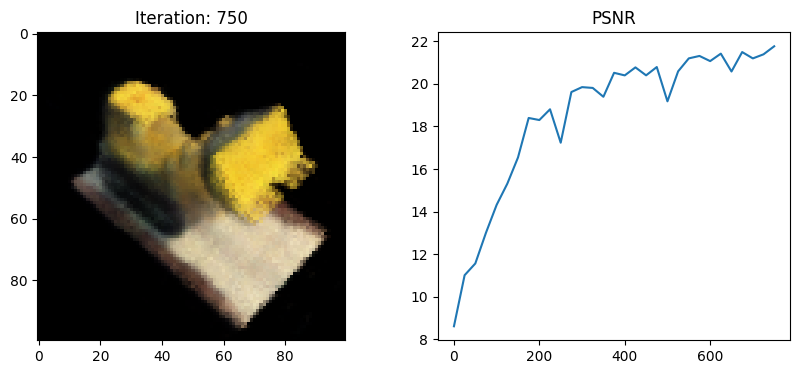

775 0.14093053817749024 secs per iter


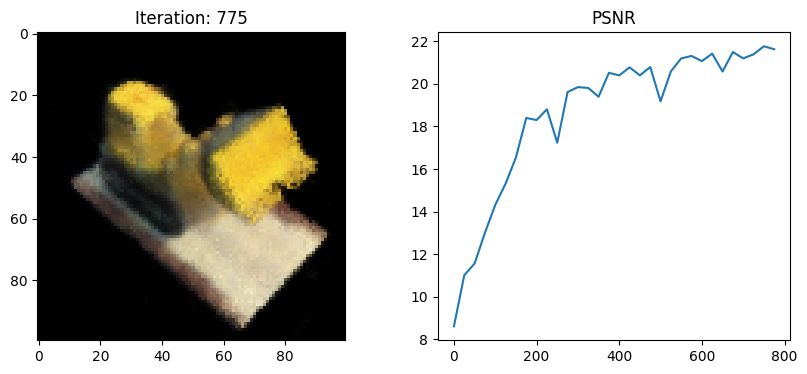

800 0.14336087226867675 secs per iter


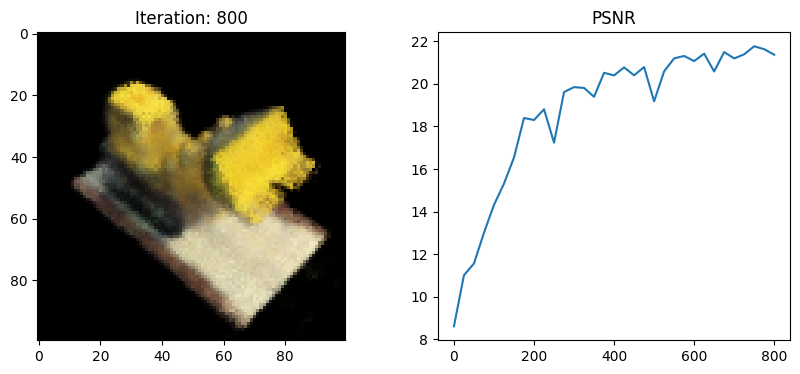

825 0.1423666000366211 secs per iter


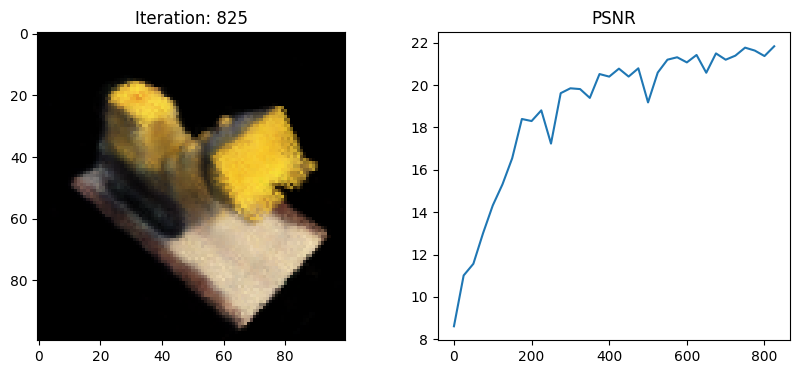

850 0.14117202758789063 secs per iter


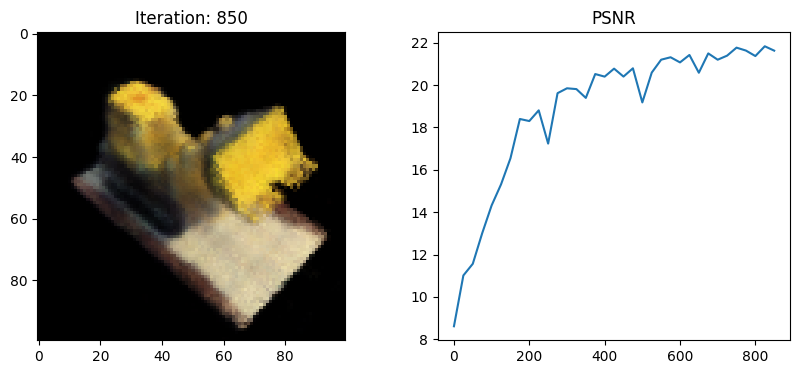

875 0.14284783363342285 secs per iter


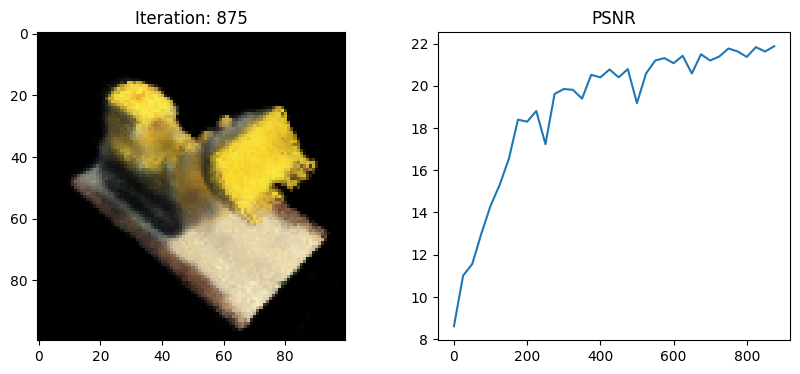

900 0.14255553245544433 secs per iter


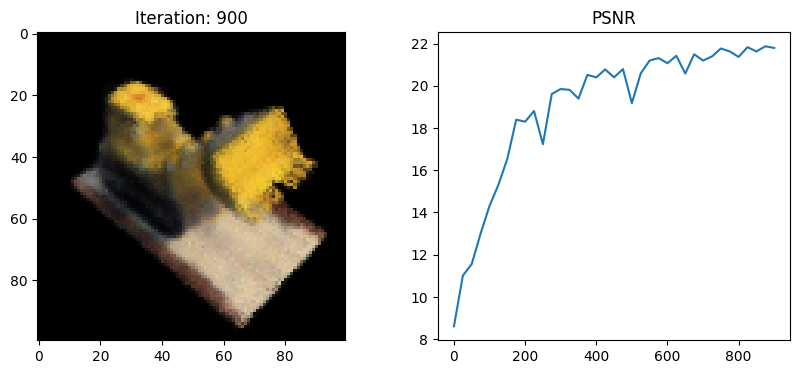

925 0.14232997894287108 secs per iter


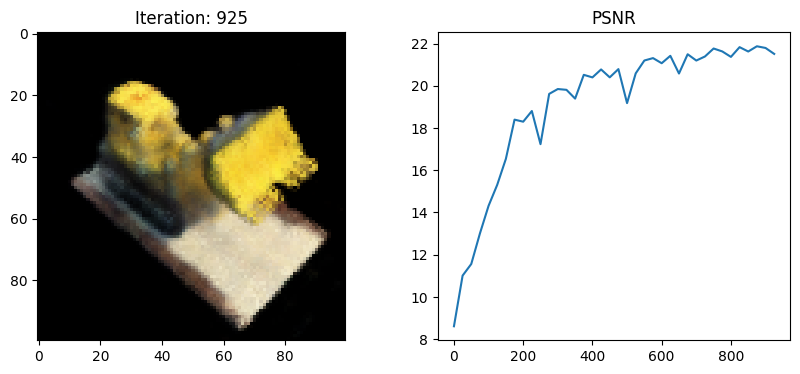

950 0.14266457557678222 secs per iter


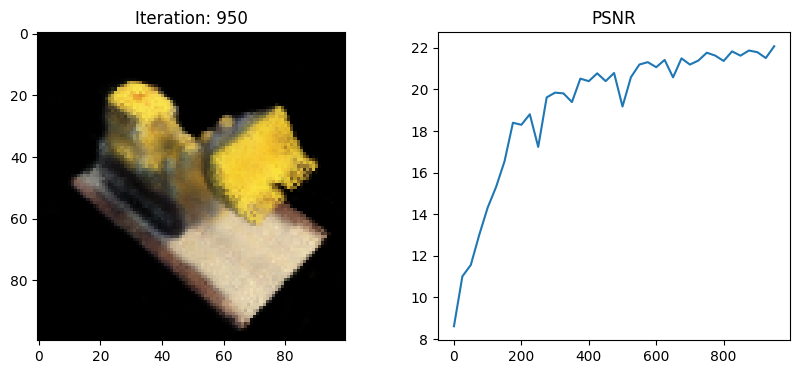

975 0.14142369270324706 secs per iter


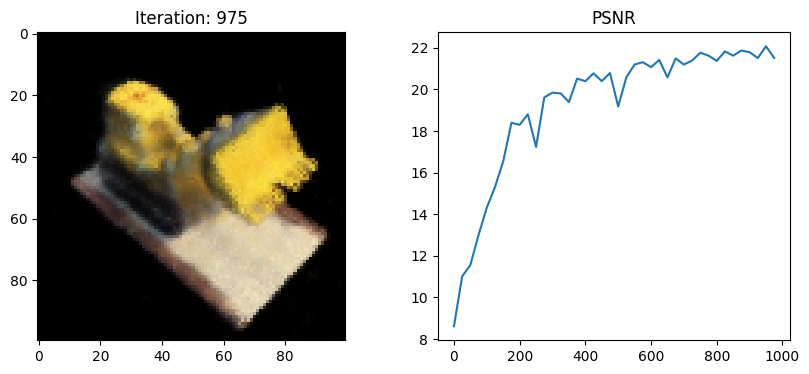

1000 0.14161893844604492 secs per iter


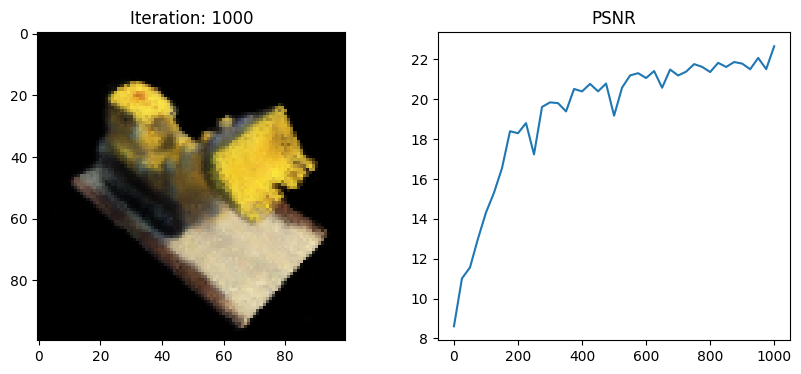

Done


In [6]:
# Initialize model with grid-based representation
model = init_model()
optimizer = tf.keras.optimizers.Adam(5e-4)

N_samples = 64
N_iters = 1000
psnrs = []
iternums = []
i_plot = 25

import time
t = time.time()
for i in range(N_iters + 1):

    # Randomly select an image and its pose
    img_i = np.random.randint(images.shape[0])
    target = images[img_i]
    pose = poses[img_i]

    # Get the rays from the camera
    rays_o, rays_d = get_rays(H, W, focal, pose)

    # Compute gradients using the improved render_rays function
    with tf.GradientTape() as tape:
        rgb, depth, acc = render_rays(model, rays_o, rays_d, near=2., far=6., N_samples=N_samples, rand=True)
        loss = tf.reduce_mean(tf.square(rgb - target))

    # Apply gradients to update model weights
    gradients = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(gradients, model.trainable_variables))

    # Log and plot every i_plot iterations
    if i % i_plot == 0:
        print(i, (time.time() - t) / i_plot, 'secs per iter')
        t = time.time()

        # Render the holdout view for logging
        rays_o, rays_d = get_rays(H, W, focal, testpose)
        rgb, depth, acc = render_rays(model, rays_o, rays_d, near=2., far=6., N_samples=N_samples)
        loss = tf.reduce_mean(tf.square(rgb - testimg))
        psnr = -10. * tf.math.log(loss) / tf.math.log(10.)

        # Record PSNR for visualization
        psnrs.append(psnr.numpy())
        iternums.append(i)

        # Plot the current rendered image and PSNR plot
        plt.figure(figsize=(10, 4))
        plt.subplot(121)
        plt.imshow(rgb)
        plt.title(f'Iteration: {i}')
        plt.subplot(122)
        plt.plot(iternums, psnrs)
        plt.title('PSNR')
        plt.show()

print('Done')


# Interactive Visualization

In [7]:
%matplotlib inline
from ipywidgets import interactive, widgets


trans_t = lambda t : tf.convert_to_tensor([
    [1,0,0,0],
    [0,1,0,0],
    [0,0,1,t],
    [0,0,0,1],
], dtype=tf.float32)

rot_phi = lambda phi : tf.convert_to_tensor([
    [1,0,0,0],
    [0,tf.cos(phi),-tf.sin(phi),0],
    [0,tf.sin(phi), tf.cos(phi),0],
    [0,0,0,1],
], dtype=tf.float32)

rot_theta = lambda th : tf.convert_to_tensor([
    [tf.cos(th),0,-tf.sin(th),0],
    [0,1,0,0],
    [tf.sin(th),0, tf.cos(th),0],
    [0,0,0,1],
], dtype=tf.float32)


def pose_spherical(theta, phi, radius):
    c2w = trans_t(radius)
    c2w = rot_phi(phi/180.*np.pi) @ c2w
    c2w = rot_theta(theta/180.*np.pi) @ c2w
    c2w = np.array([[-1,0,0,0],[0,0,1,0],[0,1,0,0],[0,0,0,1]]) @ c2w
    return c2w


def f(**kwargs):
    c2w = pose_spherical(**kwargs)
    rays_o, rays_d = get_rays(H, W, focal, c2w[:3,:4])
    rgb, depth, acc = render_rays(model, rays_o, rays_d, near=2., far=6., N_samples=N_samples)
    img = np.clip(rgb,0,1)

    plt.figure(2, figsize=(20,6))
    plt.imshow(img)
    plt.show()


sldr = lambda v, mi, ma: widgets.FloatSlider(
    value=v,
    min=mi,
    max=ma,
    step=.01,
)

names = [
    ['theta', [100., 0., 360]],
    ['phi', [-30., -90, 0]],
    ['radius', [4., 3., 5.]],
]

interactive_plot = interactive(f, **{s[0] : sldr(*s[1]) for s in names})
output = interactive_plot.children[-1]
output.layout.height = '350px'
interactive_plot

interactive(children=(FloatSlider(value=100.0, description='theta', max=360.0, step=0.01), FloatSlider(value=-…

# Render 360 Video

In [8]:
frames = []
for th in tqdm(np.linspace(0., 360., 120, endpoint=False)):
    c2w = pose_spherical(th, -30., 4.)
    rays_o, rays_d = get_rays(H, W, focal, c2w[:3,:4])
    rgb, depth, acc = render_rays(model, rays_o, rays_d, near=2., far=6., N_samples=N_samples)
    frames.append((255*np.clip(rgb,0,1)).astype(np.uint8))

import imageio
f = 'video.mp4'
imageio.mimwrite(f, frames, fps=30, quality=7)

<ipython-input-8-bc28ed268829>:2: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for th in tqdm(np.linspace(0., 360., 120, endpoint=False)):


  0%|          | 0/120 [00:00<?, ?it/s]

In [9]:
from IPython.display import HTML
from base64 import b64encode
mp4 = open('video.mp4','rb').read()
data_url = "data:video/mp4;base64," + b64encode(mp4).decode()
HTML("""
<video width=400 controls autoplay loop>
      <source src="%s" type="video/mp4">
</video>
""" % data_url)

# Edge Detection, performance check

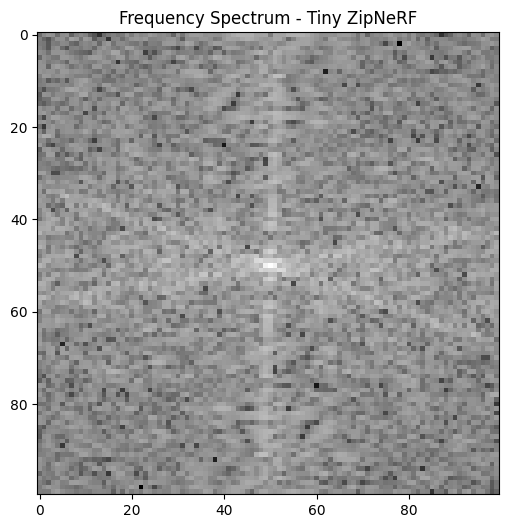

Temporal Consistency - Tiny ZipNeRF: 0.007365728
High-Frequency Content - Tiny ZipNeRF: 8.864933333333333


In [10]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

# Render a test image with the Tiny ZipNeRF model
test_image_zipnerf = render_rays(model, rays_o, rays_d, near=2., far=6., N_samples=N_samples)[0]

# Edge Frequency Analysis
def frequency_analysis(rgb_image):
    edges = cv2.Canny((rgb_image.numpy() * 255).astype(np.uint8), 100, 200)
    f_transform = np.fft.fftshift(np.fft.fft2(edges))
    magnitude_spectrum = 20 * np.log(np.abs(f_transform) + 1)
    return magnitude_spectrum

# Calculate Frequency Spectrum for Tiny ZipNeRF
magnitude_spectrum_zipnerf = frequency_analysis(test_image_zipnerf)
plt.figure(figsize=(6, 6))
plt.imshow(magnitude_spectrum_zipnerf, cmap='gray')
plt.title('Frequency Spectrum - Tiny ZipNeRF')
plt.show()

# Temporal Consistency Calculation
def temporal_consistency(frames):
    differences = []
    for i in range(1, len(frames)):
        diff = np.mean(np.abs(frames[i] - frames[i - 1]))
        differences.append(diff)
    return np.mean(differences)
def pose_shift(pose, shift=0.1):
    new_pose = np.copy(pose)
    new_pose[:3, 3] += shift
    return new_pose

# Generate a Sequence of Frames with Slight Camera Changes
camera_poses = [pose_shift(testpose, shift=0.1 * i) for i in range(5)]
frames_zipnerf = [render_rays(model, rays_o, rays_d, near=2., far=6., N_samples=N_samples)[0] for pose in camera_poses]
temporal_consistency_zipnerf = temporal_consistency(frames_zipnerf)
print("Temporal Consistency - Tiny ZipNeRF:", temporal_consistency_zipnerf)

# High-Frequency Content Analysis
def high_frequency_content(rgb_image):
    laplacian = cv2.Laplacian((rgb_image.numpy() * 255).astype(np.uint8), cv2.CV_64F)
    return np.mean(np.abs(laplacian))

hf_content_zipnerf = high_frequency_content(test_image_zipnerf)
print("High-Frequency Content - Tiny ZipNeRF:", hf_content_zipnerf)


# PSNR, SSIM and LPIPS metrics

In [11]:
# Define `rendered_images` as the list of frames rendered by the model
rendered_images = [(255 * np.clip(rgb, 0, 1)).astype(np.uint8) for rgb, _, _ in [
    render_rays(model, rays_o, rays_d, near=2., far=6., N_samples=N_samples)
    for pose in poses
]]

# Define `ground_truth_images` as the ground truth images for comparison
ground_truth_images = [img for img in images[:len(rendered_images)]]

In [15]:
import tensorflow as tf
import numpy as np
from skimage.metrics import structural_similarity as ssim
import lpips
import torch

# Initialize LPIPS model for perceptual similarity
lpips_model = lpips.LPIPS(net='vgg').cuda()  # Use .cuda() if running on a GPU

# Function to compute PSNR
def compute_psnr(image1, image2):
    # Ensure both images are float32 for compatibility
    image1 = tf.cast(image1, tf.float32)
    image2 = tf.cast(image2, tf.float32)
    mse = tf.reduce_mean(tf.square(image1 - image2))
    psnr = 20 * tf.math.log(1.0 / tf.sqrt(mse)) / tf.math.log(10.0)
    return psnr.numpy()

# Function to compute SSIM with specified data_range and smaller win_size
def compute_ssim(image1, image2):
    return ssim(image1, image2, win_size=3, data_range=1.0, channel_axis=-1)


# Function to compute LPIPS
def compute_lpips(image1, image2):
    # Convert images to PyTorch tensors and normalize
    image1 = torch.from_numpy(image1).permute(2, 0, 1).unsqueeze(0).float().cuda()
    image2 = torch.from_numpy(image2).permute(2, 0, 1).unsqueeze(0).float().cuda()
    lpips_score = lpips_model(image1, image2)
    return lpips_score.item()

# Lists to store the results
psnr_scores = []
ssim_scores = []
lpips_scores = []

# Iterate over each rendered and ground truth image pair
for rendered_img, gt_img in zip(rendered_images, ground_truth_images):
    # Ensure images are scaled to [0, 1] range if they are not already
    rendered_img = np.clip(rendered_img / 255.0, 0, 1).astype(np.float32)
    gt_img = np.clip(gt_img / 255.0, 0, 1).astype(np.float32)

    # Compute PSNR
    psnr_score = compute_psnr(rendered_img, gt_img)
    psnr_scores.append(psnr_score)

    # Compute SSIM
    ssim_score = compute_ssim(rendered_img, gt_img)
    ssim_scores.append(ssim_score)

    # Compute LPIPS
    lpips_score = compute_lpips(rendered_img, gt_img)
    lpips_scores.append(lpips_score)

# Calculate average scores for each metric
avg_psnr = np.mean(psnr_scores)
avg_ssim = np.mean(ssim_scores)
avg_lpips = np.mean(lpips_scores)

# Print results
print("Performance Metrics for Tiny ZipNeRF Model:")
print(f"Average PSNR: {avg_psnr}")
print(f"Average SSIM: {avg_ssim}")
print(f"Average LPIPS: {avg_lpips}")


Setting up [LPIPS] perceptual loss: trunk [vgg], v[0.1], spatial [off]


Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth
100%|██████████| 528M/528M [00:02<00:00, 223MB/s]


Loading model from: /usr/local/lib/python3.10/dist-packages/lpips/weights/v0.1/vgg.pth


/usr/local/lib/python3.10/dist-packages/lpips/lpips.py:107: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  self.load_state_dict(torch.load(model_path, map_location='cpu'), st

Performance Metrics for Tiny ZipNeRF Model:
Average PSNR: 13.91562271118164
Average SSIM: 0.6446782946586609
Average LPIPS: 0.45359386086463926
